# Enriching Grants part 2: Adding Publications Information from Dimensions 

In this tutorial we enrich a grants dataset by adding information about number of publications per grant. This information will then let us draw some interesting statistics about the impact of grants & funders from the point of view of research outputs. 

This tutorial builds on the previous one, *Matching your grants records to Dimensions*, and it assumes that our grants list already includes Dimensions IDs for each grant. 

The grants dataset we are starting from focuses on the broad topic of 'vaccines' and can be [downloaded here](http://api-sample-data.dimensions.ai/data/vaccines-grants-sample-part-1.csv). 

In [1]:
import datetime
print("==\nCHANGELOG\nThis notebook was last run on %s\n==" % datetime.date.today().strftime('%b %d, %Y'))

==
CHANGELOG
This notebook was last run on Jan 25, 2022
==


## Prerequisites

This notebook assumes you have installed the [Dimcli](https://pypi.org/project/dimcli/) library and are familiar with the ['Getting Started' tutorial](https://api-lab.dimensions.ai/cookbooks/1-getting-started/1-Using-the-Dimcli-library-to-query-the-API.html).


In [2]:
!pip install dimcli tqdm plotly -U --quiet 

import dimcli
from dimcli.utils import *

import sys, time, json
import pandas as pd
from tqdm.notebook import tqdm as progressbar

import plotly.express as px
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)

print("==\nLogging in..")
# https://digital-science.github.io/dimcli/getting-started.html#authentication
ENDPOINT = "https://app.dimensions.ai"
if 'google.colab' in sys.modules:
  import getpass
  KEY = getpass.getpass(prompt='API Key: ')  
  dimcli.login(key=KEY, endpoint=ENDPOINT)
else:
  KEY = ""
  dimcli.login(key=KEY, endpoint=ENDPOINT)
dsl = dimcli.Dsl()

Searching config file credentials for 'https://app.dimensions.ai' endpoint..


==
Logging in..
Dimcli - Dimensions API Client (v0.9.6)
Connected to: <https://app.dimensions.ai/api/dsl> - DSL v2.0
Method: dsl.ini file


## Reusing the sample grants data from part-1

First, we are going to load the sample grants dataset from part-1 of this tutorial: ["vaccines-grants-sample-part-1.csv"](http://api-sample-data.dimensions.ai/data/vaccines-grants-sample-part-1.csv). 

In [3]:
grants = pd.read_csv("http://api-sample-data.dimensions.ai/data/vaccines-grants-sample-part-1.csv")

The dataset that was created in part-1 of this tutorial contains ~1000 grants. Even if we had more, the same steps descrived in what follows still apply (but of course it'll take more time to extract and process the data).

In [4]:
# remove rows without a Dimensions ID
grants.dropna(subset=["Dimensions ID"], inplace=True)
grantsids = grants['Dimensions ID'].to_list()

Now we can preview the contents of the file.

In [5]:
grants.head(10)

,Grant Number,Title,Funding Amount in USD,Start Year,End Year,Funder,Funder Country,Dimensions ID
0,30410203277,疫苗－整体方案,1208.0,2004,2004,National Natural Science Foundation of China,China,grant.8172033
1,620792,Engineering Inhalable Vaccines,26956.0,2017,2018,Natural Sciences and Engineering Research Council,Canada,grant.7715379
2,599115,Engineering Inhalable Vaccines,26403.0,2016,2017,Natural Sciences and Engineering Research Council,Canada,grant.6962629
3,251564,HIV Vaccine research,442366.0,2003,2007,National Health and Medical Research Council,Australia,grant.6723913
4,334174,HIV Vaccine Development,236067.0,2005,2009,National Health and Medical Research Council,Australia,grant.6722306
5,910292,Dengue virus vaccine.,130890.0,1991,1993,National Health and Medical Research Council,Australia,grant.6716312
6,578221,Engineering Inhalable Vaccines,27386.0,2015,2016,Natural Sciences and Engineering Research Council,Canada,grant.5526688
7,IC18980360,Schistosomiasis Vaccine Network.,0.0,1998,2000,European Commission,Belgium,grant.3733803
8,7621798,Pneumococcal Ribosomal Vaccines,46000.0,1977,1980,Directorate for Biological Sciences,United States,grant.3274273
9,255890,Rational vaccine design,7138.0,2003,2004,Natural Sciences and Engineering Research Council,Canada,grant.2936015


## Extracting linked Publications data from Dimensions

> Tip: see the [API data model](https://docs.dimensions.ai/dsl/data-sources.html) page for more details on which relationships exist between publications, grants and the other Dimensions source types. 

The generic query for extracting publications linked to a grant goes like this:

```
search publications 
  where supporting_grant_ids in ['grant.3274273', 'grant.2936015', etc.. ] 
return 
  publications[title+doi+year+supporting_grant_ids] 
```

This query is pretty straighforward. Note that, since we are extracting a merged list publications for several grants at the same time, we are including in the results the 'supporting_grant_ids' data (`return publications[title+doi+year+supporting_grant_ids]`). This will allow us to 'disentangle' the list later on so to know exactly how many publications are linked to each single grant.

### Building a looped extraction

Since we are using the query above to extract linked publications for thousands of grants there are a few more things to keep in mind: 

* **Grants IDs per query.** In general, the API can handle up to 300-400 grants IDs per query. This is number isn't set in stone though, but rather it should fine-tuned by trial and error, also considering the impact of the following points.
* **Query complexity.** If the query contains many other constraints (ie `where` clauses) these will impact the query complexity/speed, hence indirectly the max number of grants IDs it can handle.
* **Response time.** It's always useful to keep an eye on the time it takes to get back results: for example, it may be more efficient to retrieve less grants per query and have more queries overall. 
* **Total number of records.** One should keep an eye on the overall number of records (= publications) coming back from a single query: if it's up to 1000, one `dsl.query` statement is enough. If instead there are more than 1000 records, that means we need to add another inner loop to extract all the data,  or use the `dsl.query_iterative` helper function. 



In [6]:
#
# the main query
#
q = """search publications 
          where supporting_grant_ids in {} 
       return publications[title+doi+year+supporting_grant_ids]"""

#
# let's loop through all grants IDs in chunks and query Dimensions 
#
results = []
for chunk in progressbar(list(chunks_of(list(grantsids), 200))):
    data = dsl.query_iterative(q.format(json.dumps(chunk)), verbose=False)
    results += data.publications
    time.sleep(1)

#
# put the data into a dataframe, remove duplicates and save
#
pubs = pd.DataFrame().from_dict(results)
print("Publications found: ", len(pubs))
pubs.drop_duplicates(subset='doi', inplace=True)
print("Unique publications found: ", len(pubs))
# turning lists into strings to ensure compatibility with CSV loaded data
# see also: https://stackoverflow.com/questions/23111990/pandas-dataframe-stored-list-as-string-how-to-convert-back-to-list
pubs['supporting_grant_ids'] = pubs['supporting_grant_ids'].apply(lambda x: ','.join(map(str, x))) 

  0%|          | 0/6 [00:00<?, ?it/s]

Publications found:  82027
Unique publications found:  78239


Let's preview the publications data now:

In [7]:
pubs.head(5)

,doi,supporting_grant_ids,title,year
0,10.1158/1078-0432.ccr-21-3659,"grant.9018788,grant.2438856,grant.2440246",Phase I trial combining chemokine-targeting wi...,2022
1,10.1093/jac/dkab490,"grant.7751928,grant.2691196",Proximal tubular dysfunction in pregnant women...,2022
2,10.1038/s41375-021-01494-w,"grant.6499387,grant.8884725,grant.7073139",Inhibition of the deubiquitinating enzyme USP4...,2022
3,10.1016/s1470-2045(21)00718-x,"grant.3804391,grant.3536471,grant.3536478",Trastuzumab with trimodality treatment for oes...,2022
4,10.1080/2162402x.2021.2020983,"grant.2440246,grant.7922722,grant.2438818,gran...",Identification of Claudin 6-specific HLA class...,2022


### Final step: grouping publications by grant

The publications dataset we obtained can be 'turned inside out' so that we have one row per grant, and information about how many publications are linked to it. 

One approach is to use a simple function that from a `grantID` will return how many publications are related to it. 

In [8]:
def pubs_for_grantid(grantid):
  global pubs
  return pubs[pubs['supporting_grant_ids'].str.contains(grantid)]

Using this function, we can loop through the original list of grants and calculate the tot number of pubs for each of them. 

The results are then used to enrich the original table with one extra column called 'pubs'.

In [9]:
l = []
for x in progressbar(grantsids):
  l.append(len(pubs_for_grantid(x)))
grants['Resulting Publications'] = l

  0%|          | 0/1158 [00:00<?, ?it/s]

Let's now preview the data:

In [17]:
# grants.to_csv("vaccines-grants-sample-part-2.csv", index=False)
grants.head(5)

,Grant Number,Title,Funding Amount in USD,Start Year,End Year,Funder,Funder Country,Dimensions ID,Resulting Publications
0,30410203277,疫苗－整体方案,1208.0,2004,2004,National Natural Science Foundation of China,China,grant.8172033,0
1,620792,Engineering Inhalable Vaccines,26956.0,2017,2018,Natural Sciences and Engineering Research Council,Canada,grant.7715379,0
2,599115,Engineering Inhalable Vaccines,26403.0,2016,2017,Natural Sciences and Engineering Research Council,Canada,grant.6962629,0
3,251564,HIV Vaccine research,442366.0,2003,2007,National Health and Medical Research Council,Australia,grant.6723913,0
4,334174,HIV Vaccine Development,236067.0,2005,2009,National Health and Medical Research Council,Australia,grant.6722306,1


## Data Exploration

Now we can explore a bit the grants+publications dataset using the [plotly express](https://plot.ly/python/plotly-express/) library. 

### Publications per grant by year and funding amount

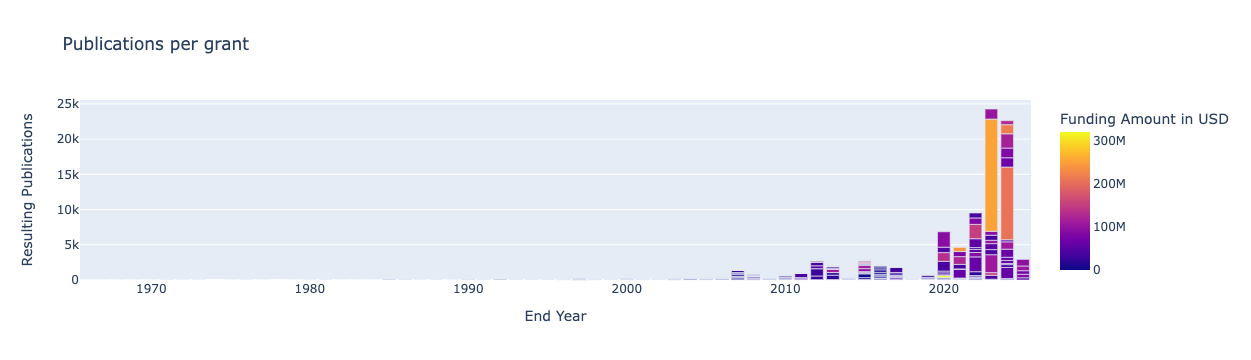

In [11]:
px.bar(grants, 
       x="End Year", y="Resulting Publications", 
       color="Funding Amount in USD", 
       hover_name="Title", 
       hover_data=['Dimensions ID', 'Start Year', 'End Year', 'Funder', 'Funder Country', "Grant Number"],
       title=f"Publications per grant")

### Publications per grant by country

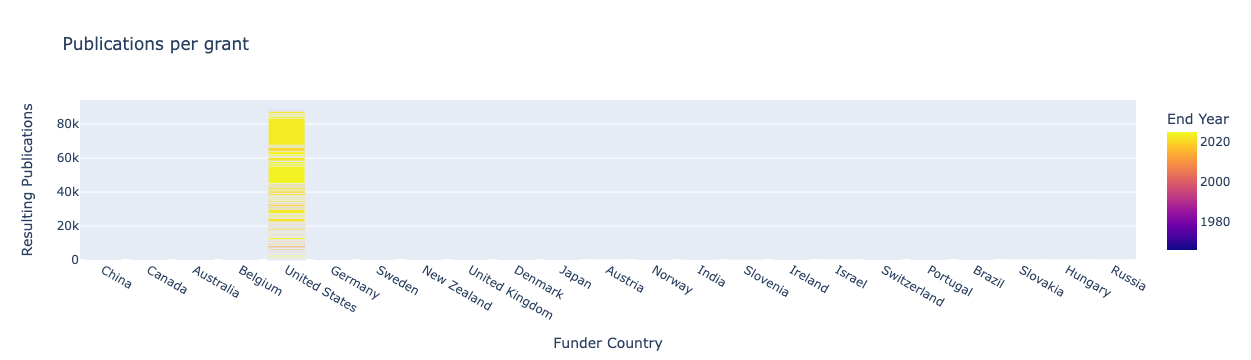

In [12]:
px.bar(grants, 
       x="Funder Country", y="Resulting Publications", 
       color="End Year", 
       hover_name="Title", 
       hover_data=['Dimensions ID', 'Start Year', 'End Year', 'Funder', 'Funder Country'],
       title=f"Publications per grant")

### Correlation of num of publications to grant length 

/Users/michele.pasin/Envs/jupyterlab/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



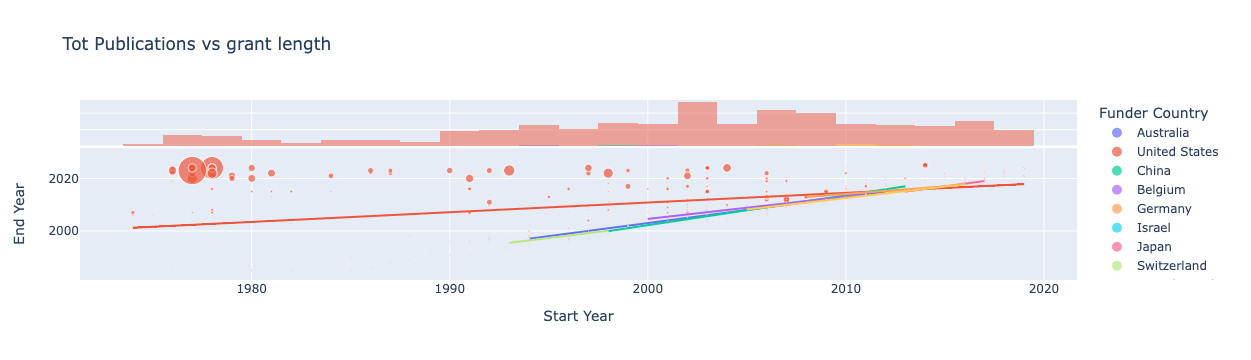

In [13]:
px.scatter(grants.query('`Resulting Publications` > 0'),  
           y="End Year", x="Start Year", 
           size="Resulting Publications",
           color="Funder Country", 
           marginal_x="histogram",
           hover_name="Title", 
           hover_data=['Dimensions ID', 'Start Year', 'End Year', 'Funder', 'Funder Country'],
           trendline="ols", 
           title=f"Tot Publications vs grant length")

### Publications by grant funder

In [14]:
funders = grants.query('`Resulting Publications` > 0')\
    .groupby(['Funder', 'Funder Country'], as_index=False)\
    .sum().sort_values(by=["Resulting Publications"], ascending=False)

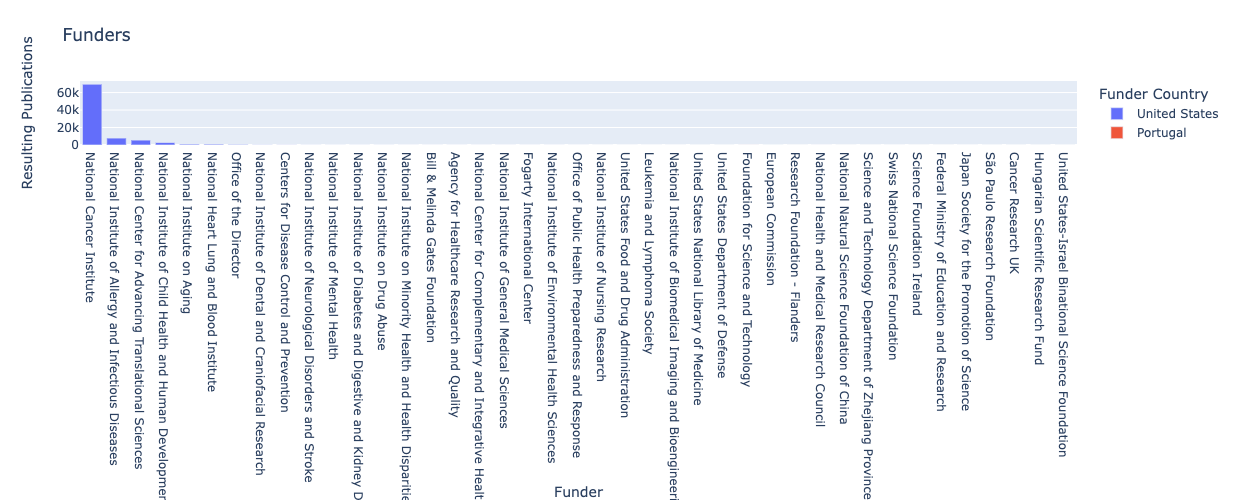

In [15]:
px.bar(funders,  
       y="Resulting Publications", x="Funder", 
       color="Funder Country",
       hover_name="Funder", 
       hover_data=['Funder', 'Funder Country'], 
       height=500,
       title=f"Funders")

### Publications by grant funder vs funding amount

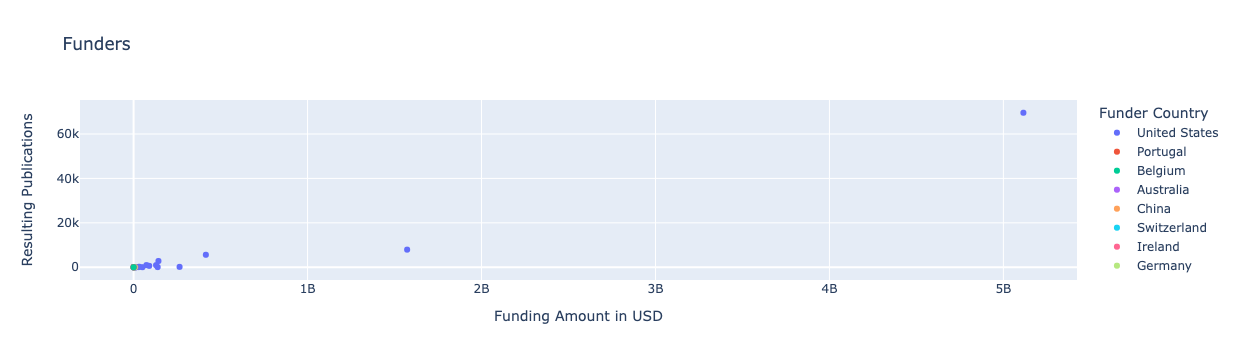

In [16]:
px.scatter(funders,  
           y="Resulting Publications", x="Funding Amount in USD", 
           color="Funder Country",
           hover_name="Funder", 
           hover_data=['Funder', 'Funder Country'], 
           title=f"Funders")

--- 

## Conclusion

In this tutorial we have enriched a grants dataset on the topic of 'vaccines' by adding information about number of publications per grant. 
This information has let us draw some interesting statistics about the impact of grants & funders from the point of view of research outputs. 

In the next tutorial we will continue the analysis by enriching the data also with patents and clinical trials information. 